In [1]:
import geopandas as gpd
from pathlib import Path
import pandas as pd

from processing.parse_data import load_insar_time_series, pearsonr_by_pid, align_ts_by_pid
from processing.statistics import get_velocity_and_displacement, get_velocity_variability, get_acceleration

folder_path = './input_data'
bbox_path = './input_data/bbox.geojson'
reference_epsg = 4326
working_epsg = 3945
columns_to_plot = ['mean_velocity', 'acceleration']

folder = Path(folder_path)
filepaths = [path for path in folder.rglob('*.csv')]
print('Found ' + str(len(filepaths)) + ' files, loading...')
bbox = gpd.read_file(bbox_path)
gdf_infos, df_ts = load_insar_time_series(filepaths, bbox)
print('Loaded ' + str(len(gdf_infos)) + ' insar points of measures.')

Found 12 files, loading...
Loaded 214 insar points of measures.


In [66]:
df_pearson = pearsonr_by_pid(df_ts)
df_ts_new = df_ts.merge(df_pearson, on =['pid', 'start_year'], how='left')
df_ts_new = align_ts_by_pid(df_ts_new, combine=False, pearson_threshold=0.2)
velocity_and_displacement = df_ts_new.apply(get_velocity_and_displacement, axis=1)
df_ts_new[['velocity', 'total_displacement']] = pd.DataFrame(velocity_and_displacement.tolist(), index=velocity_and_displacement.index)
df_ts_new[['velocity_std']] = df_ts_new.apply(get_velocity_variability, axis=1)
df_ts_new[['acceleration']] = df_ts_new.apply(get_acceleration, axis=1)

df_aligned = df_ts_new.merge(gdf_infos, on=['pid', 'start_year'])

date_columns = [col for col in df_ts_new.columns if isinstance(col, pd.Timestamp)]
df_aligned = gpd.GeoDataFrame(df_aligned, geometry='geometry', crs=gdf_infos.crs)

df_out = df_aligned.copy()
df_out.columns = [str(col.strftime('%Y-%m-%d')) if col in date_columns else col for col in df_out.columns]
df_out.to_file('ts_aligned_by_pid.gpkg')

In [67]:
df_velocity_mean = df_out.groupby('pid').agg({'velocity': 'mean'}).rename(columns={'velocity': 'mean_velocity'})
df_displacement_sum = df_out.groupby('pid').agg({'total_displacement': 'sum'})
df_velocity_std = df_out.groupby('pid').agg({'velocity_std': 'max'})
df_acceleration = df_out.groupby('pid').agg({'acceleration': 'max'})

df_stats = df_velocity_mean.merge(df_displacement_sum, on ='pid')
df_stats = df_stats.merge(df_velocity_std, on ='pid')
df_stats = df_stats.merge(df_acceleration, on ='pid')
df_stats = df_stats.merge(gdf_infos, on=['pid'])
df_stats = gpd.GeoDataFrame(df_stats, geometry='geometry', crs=gdf_infos.crs)
df_stats.to_file('results_stats_by_pid.gpkg')


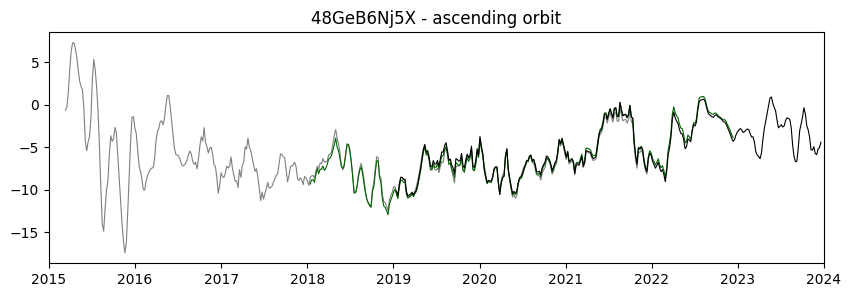

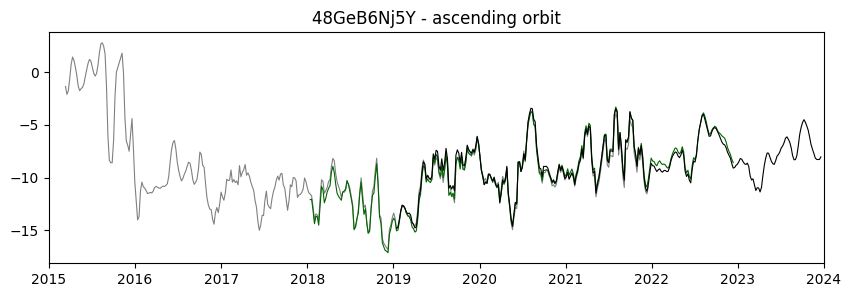

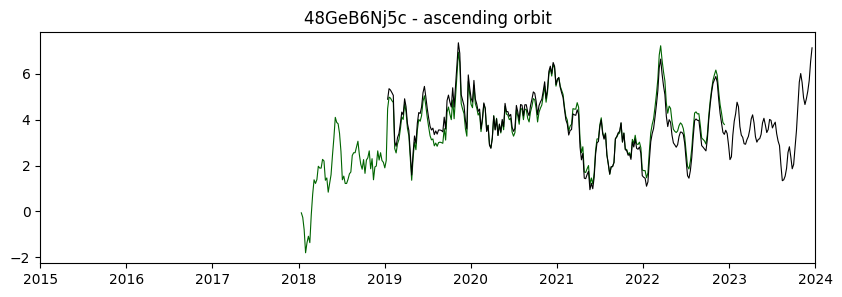

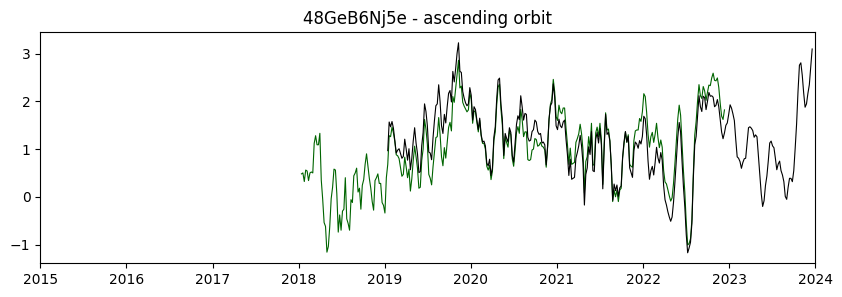

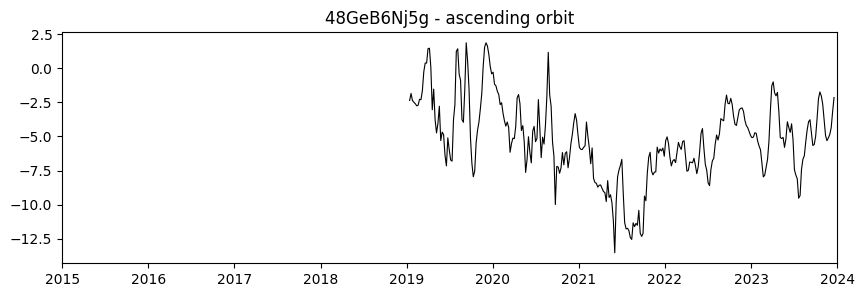

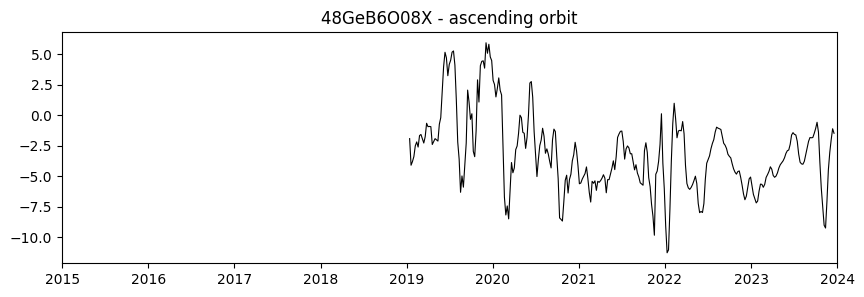

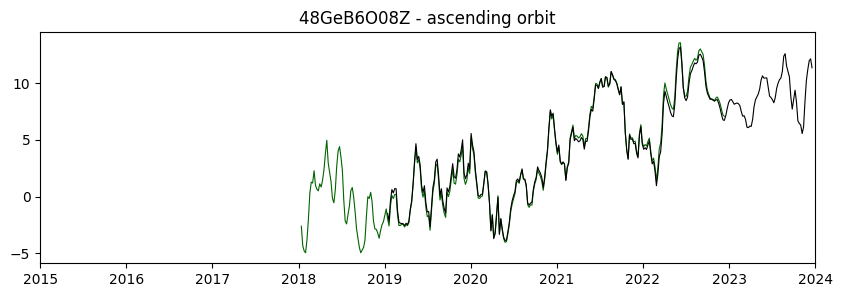

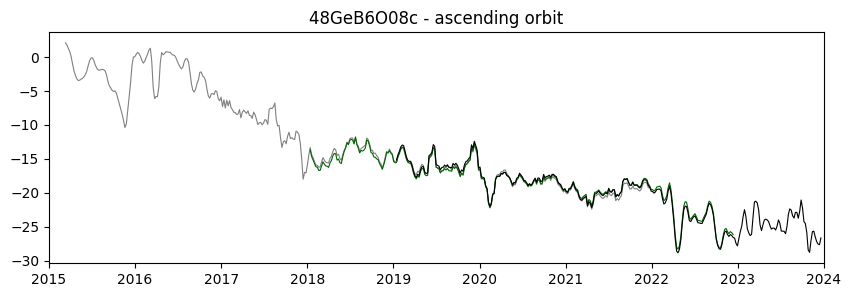

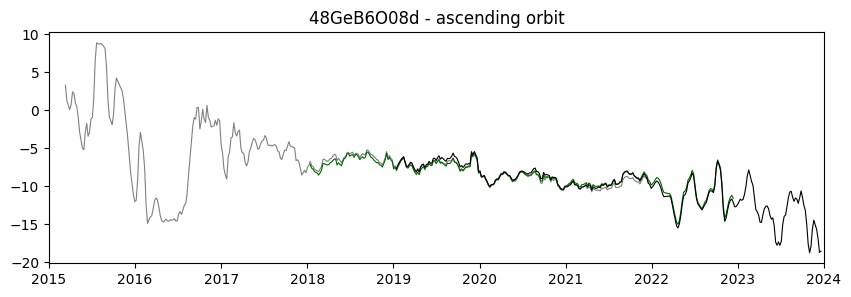

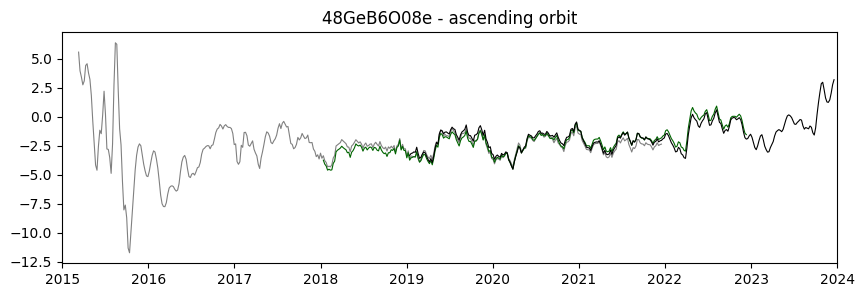

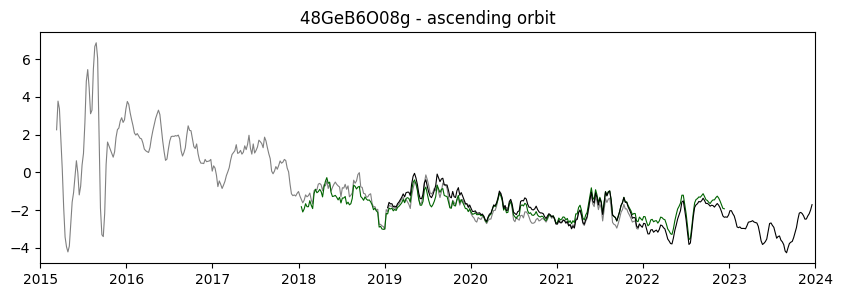

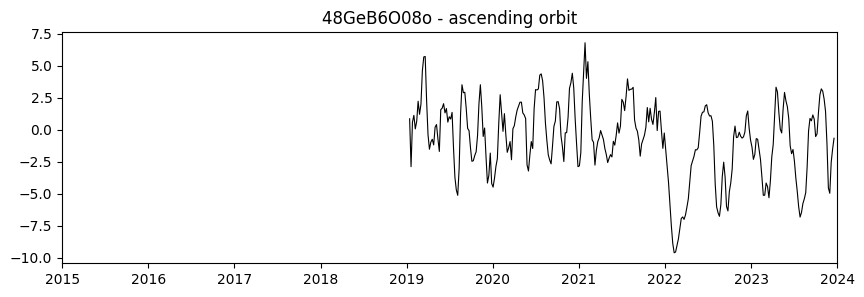

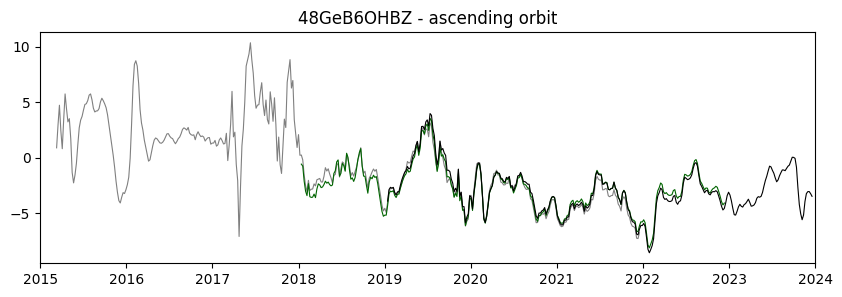

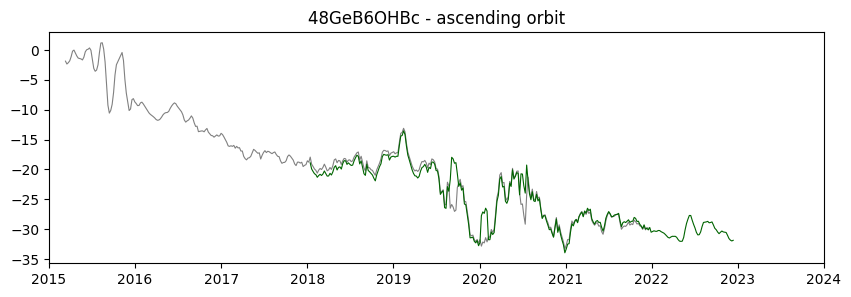

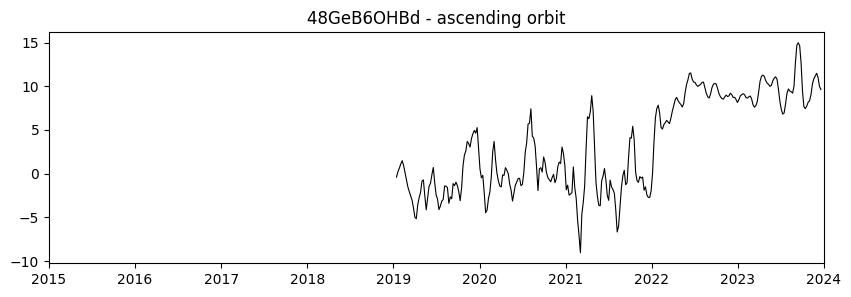

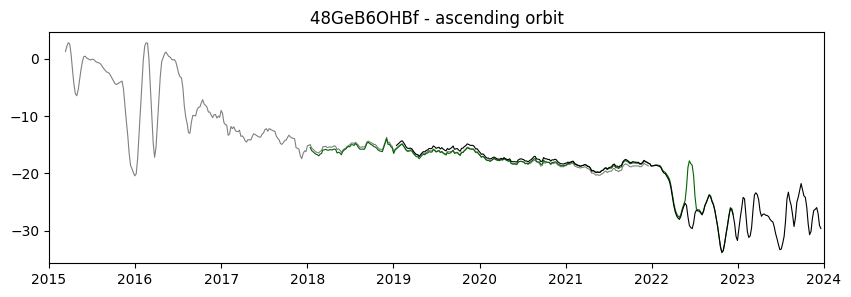

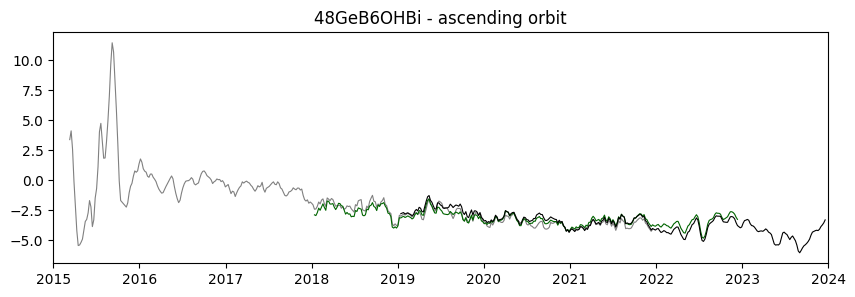

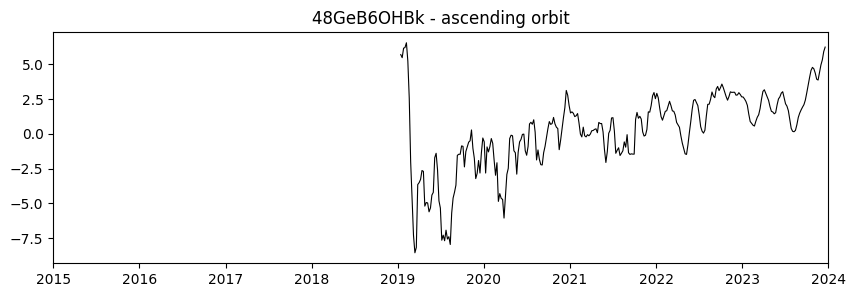

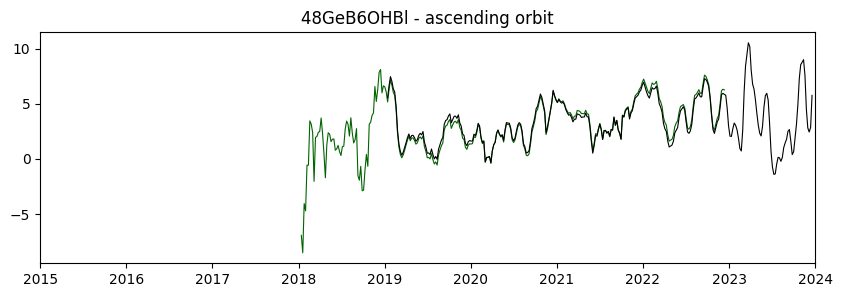

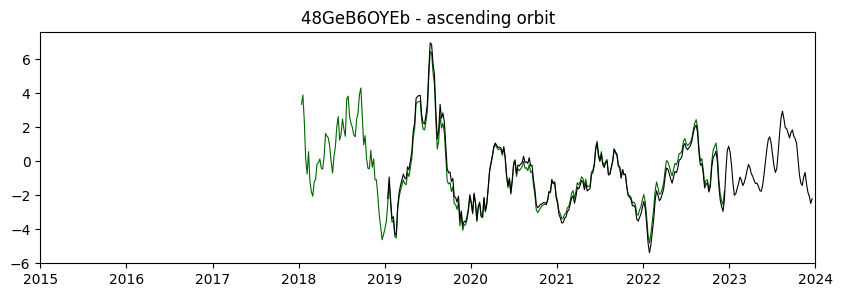

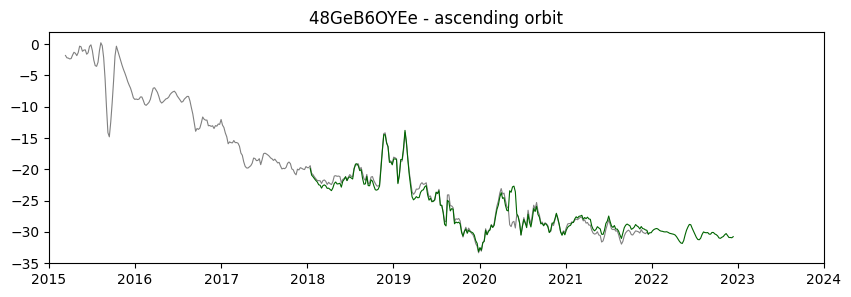

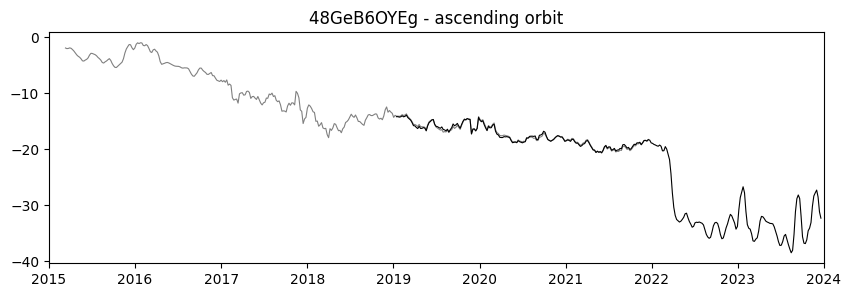

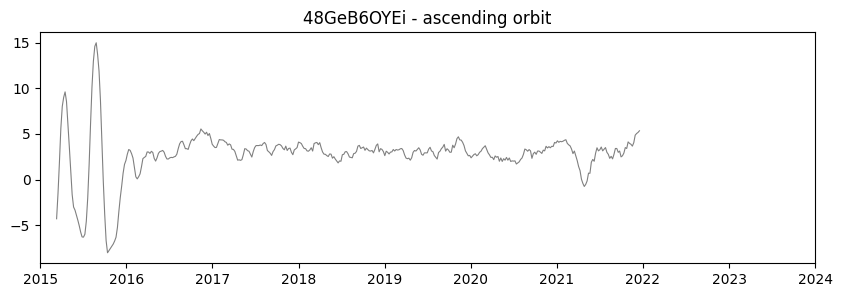

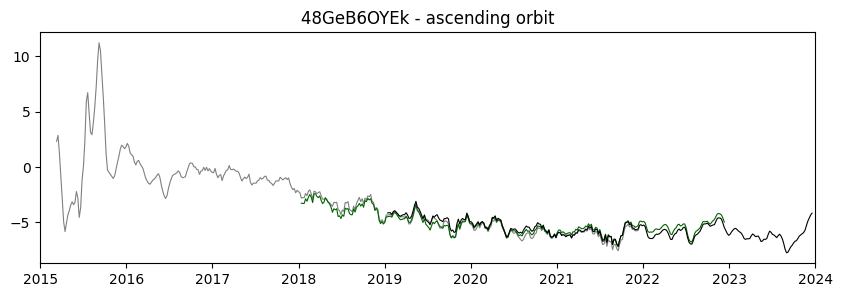

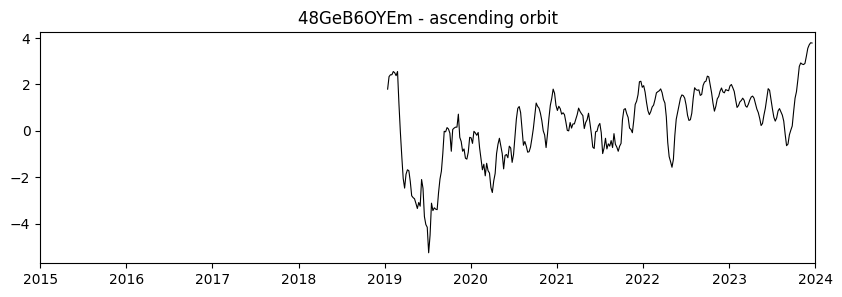

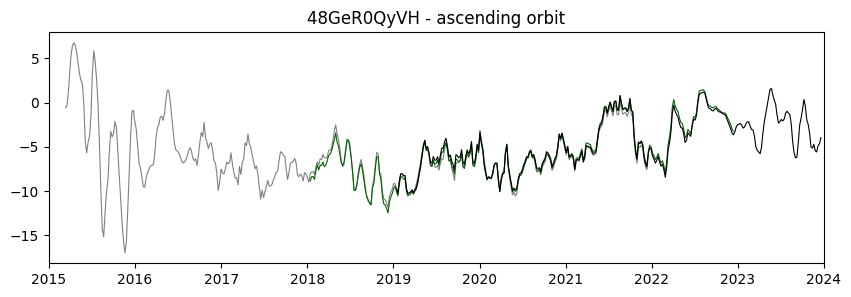

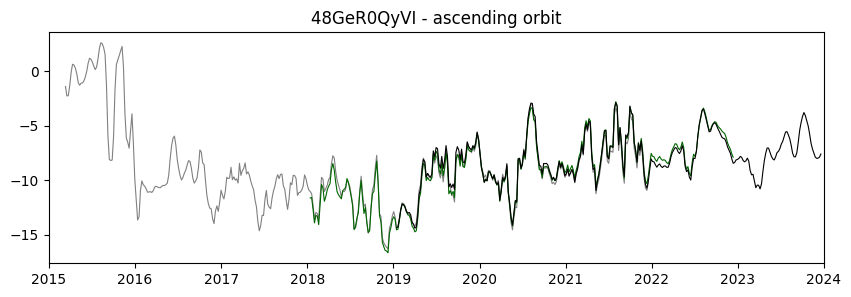

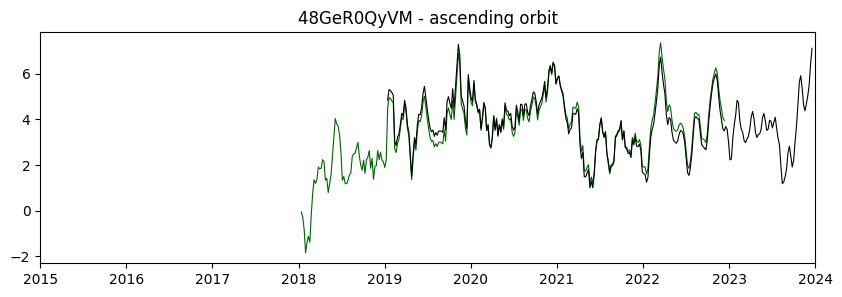

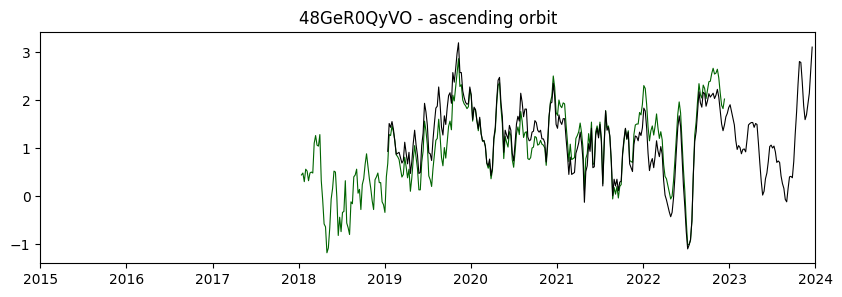

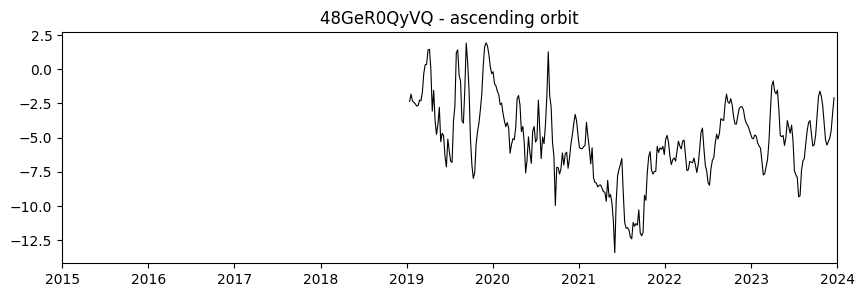

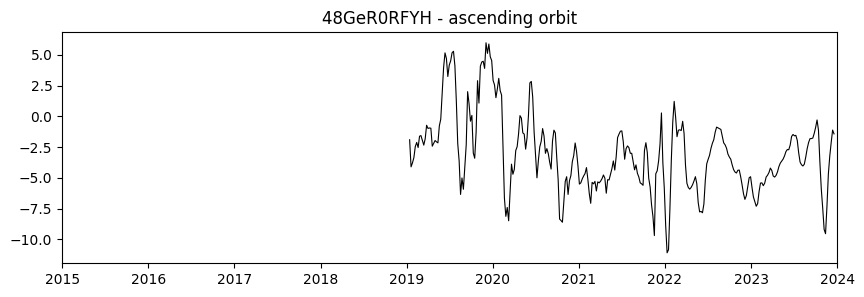

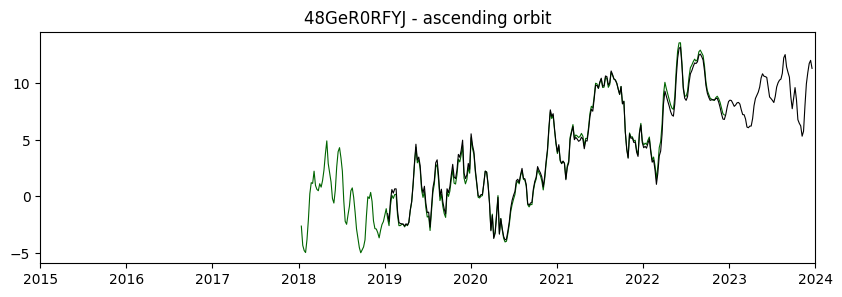

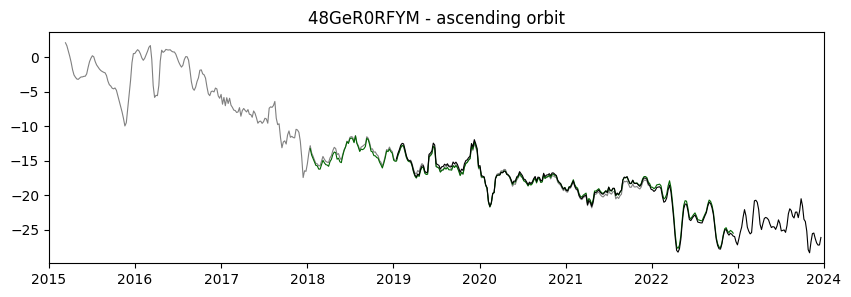

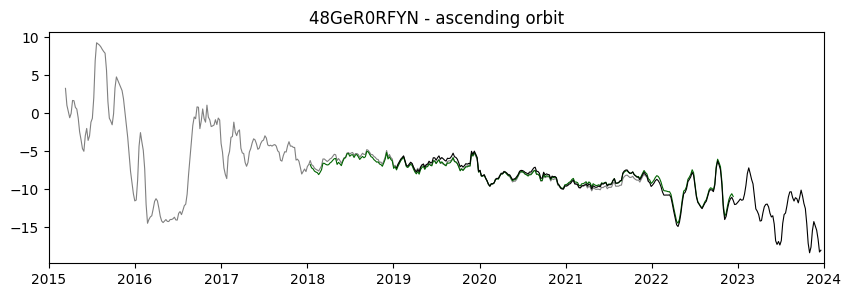

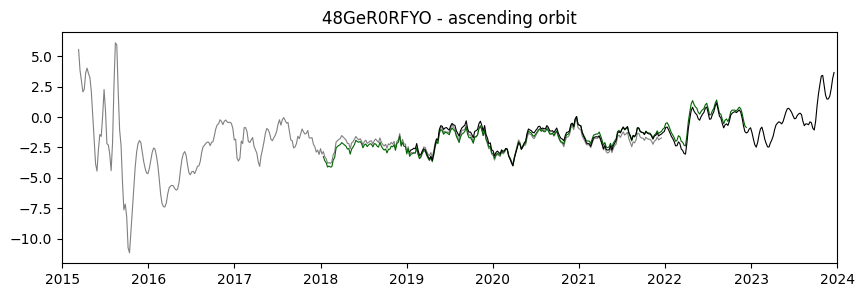

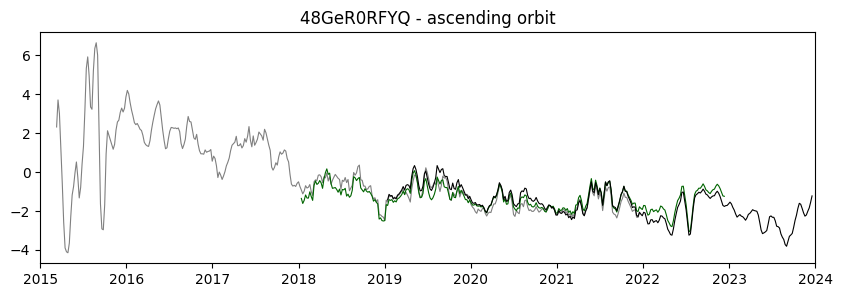

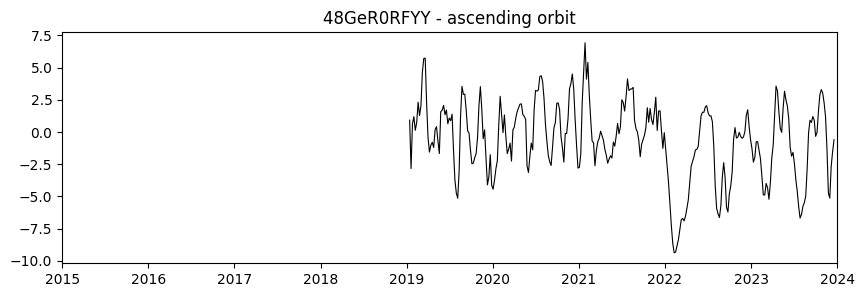

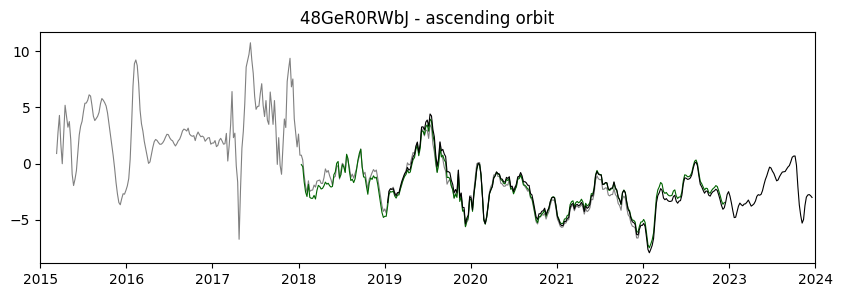

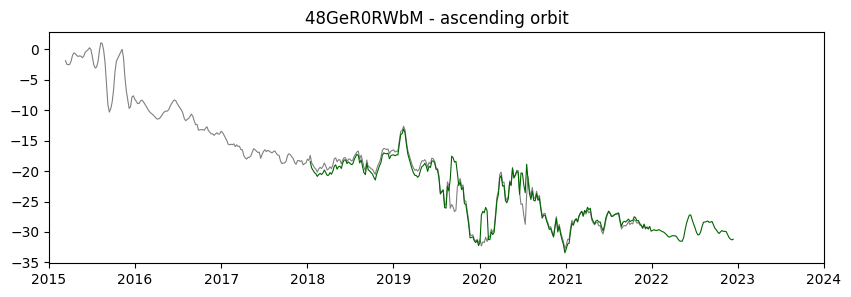

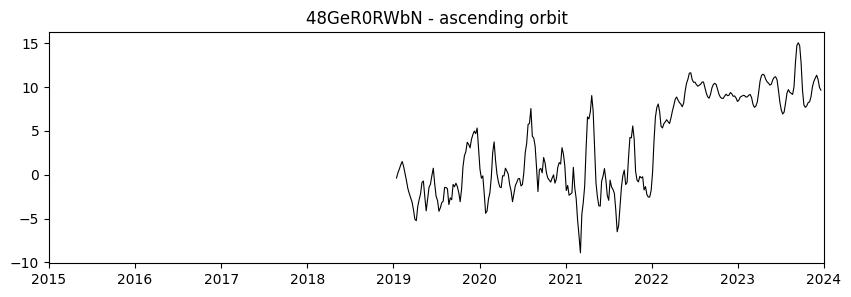

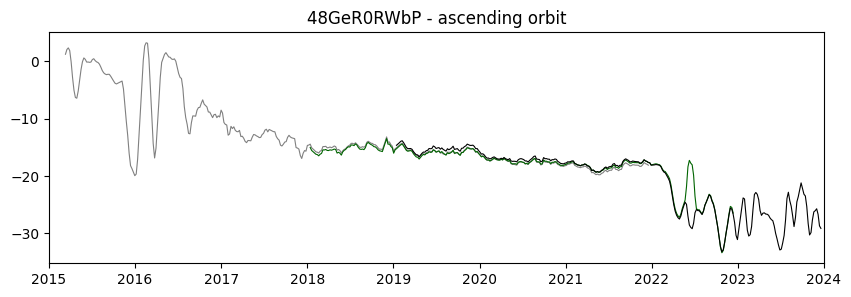

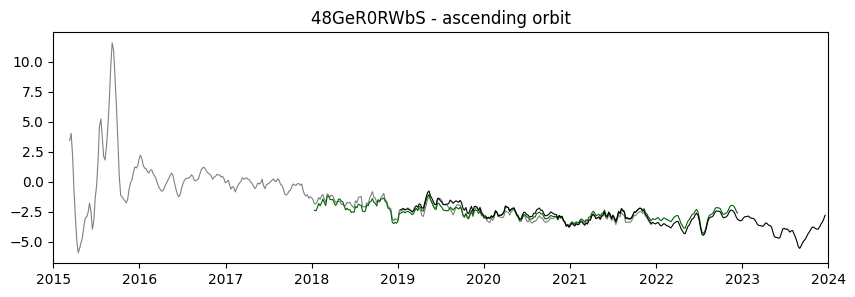

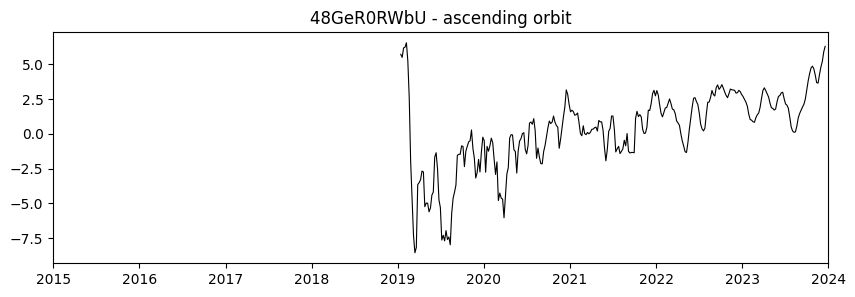

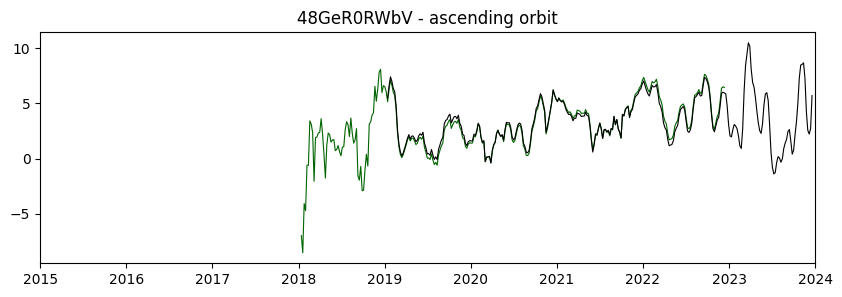

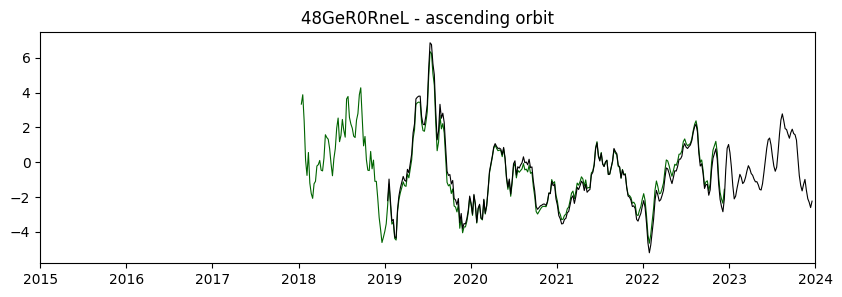

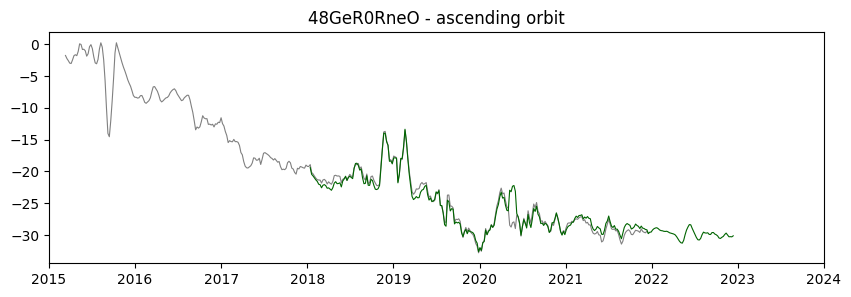

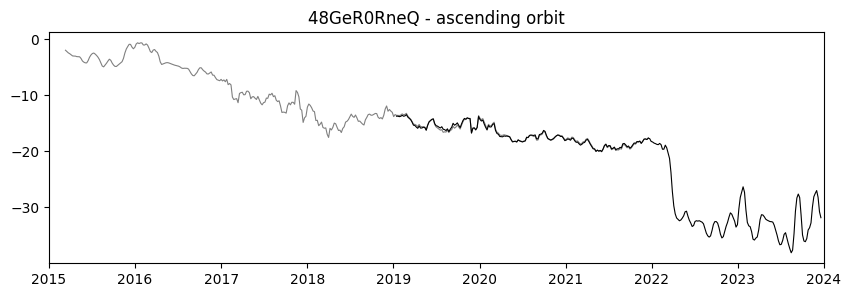

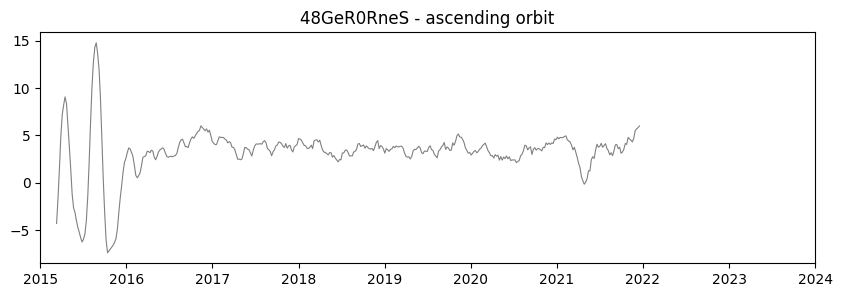

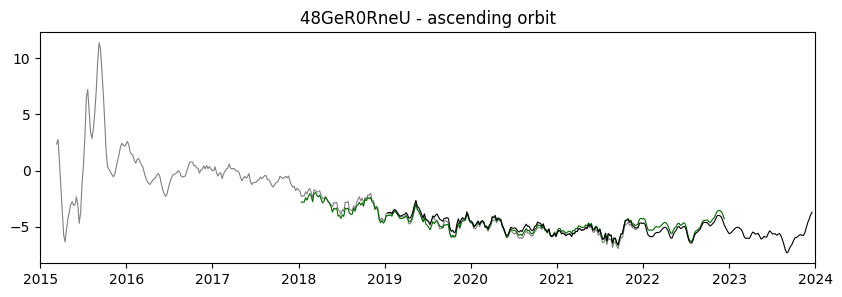

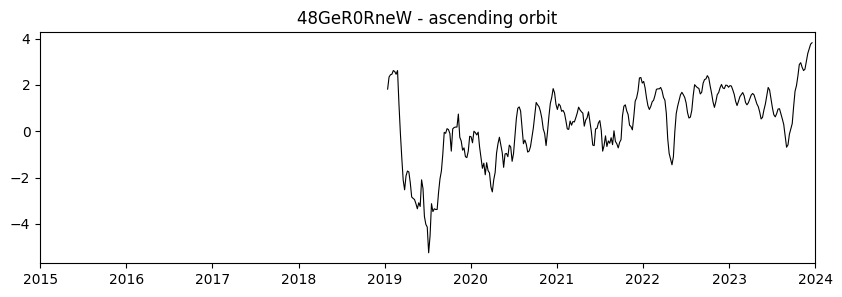

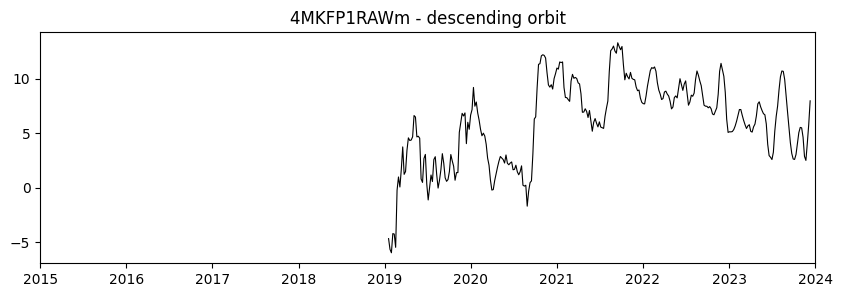

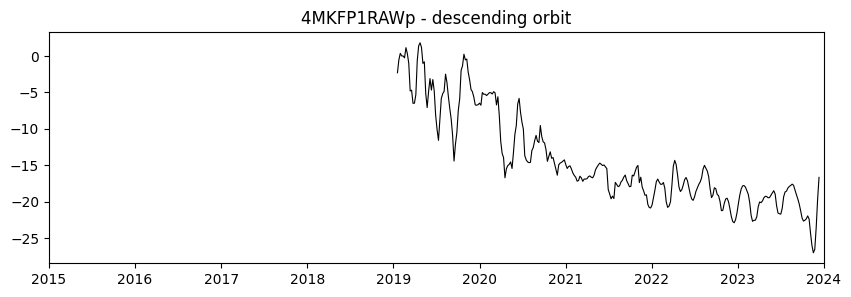

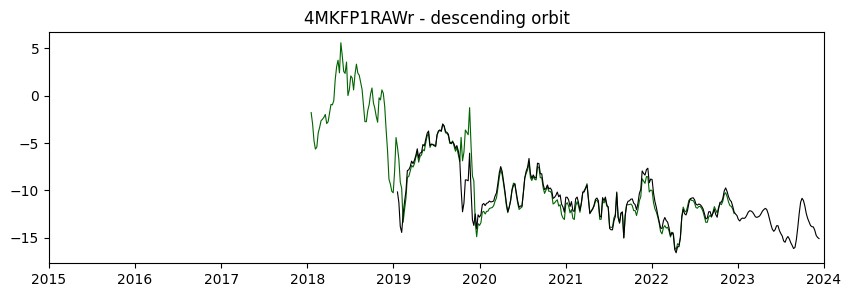

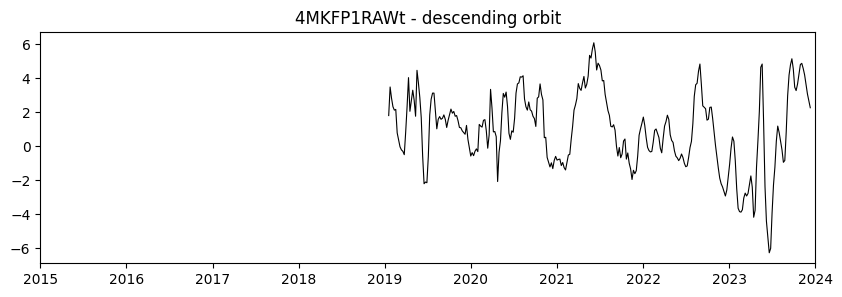

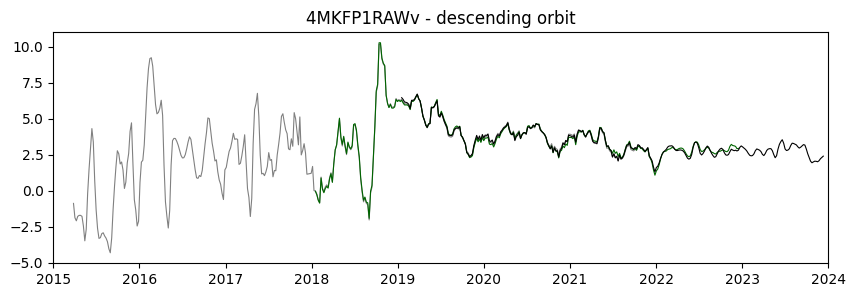

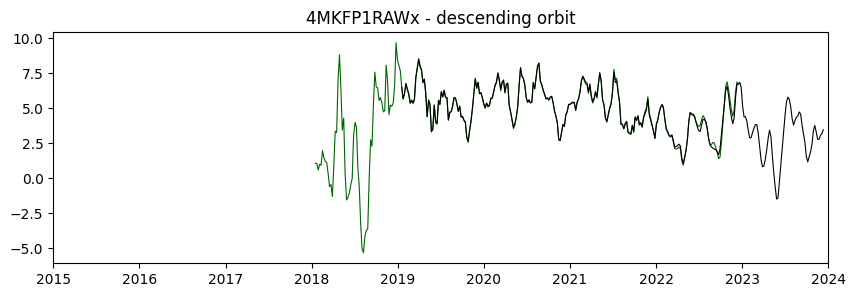

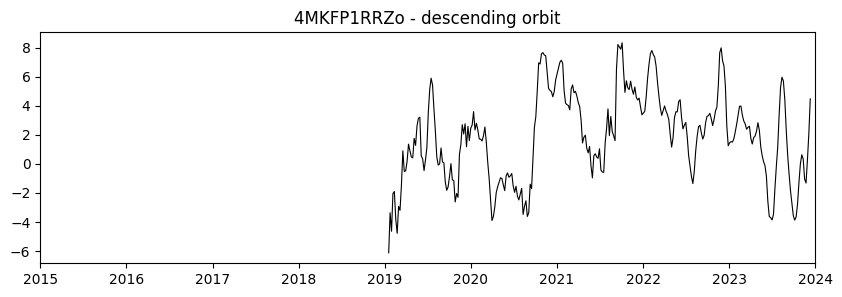

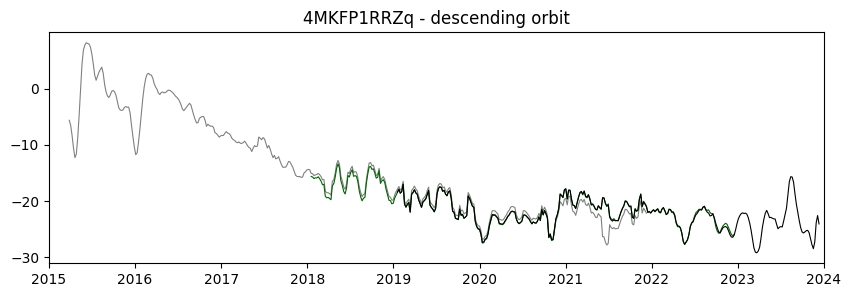

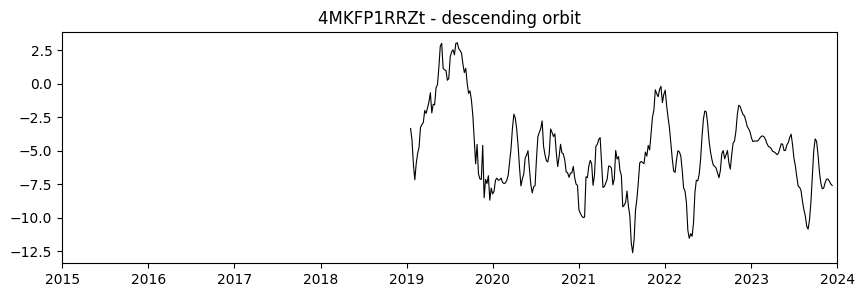

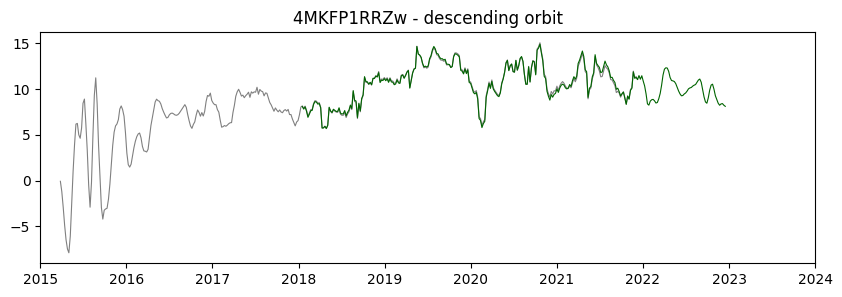

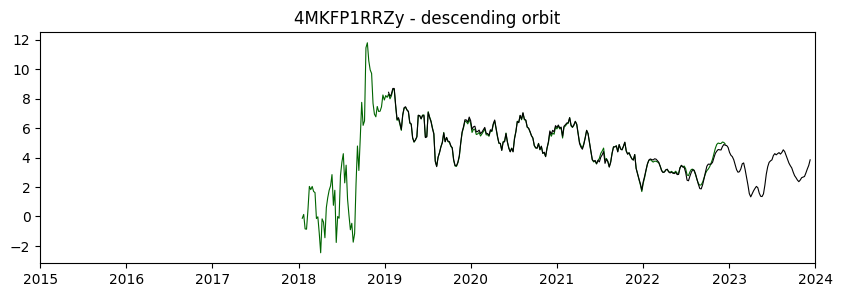

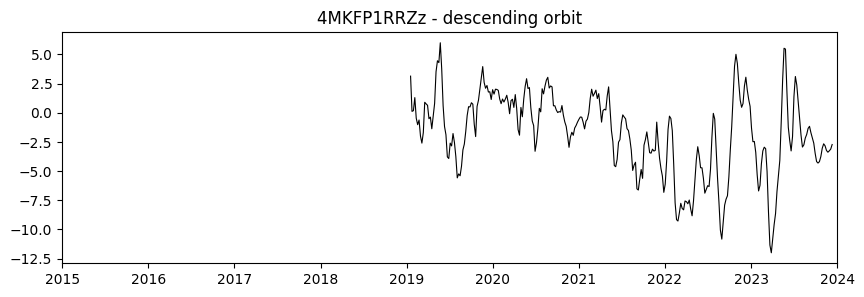

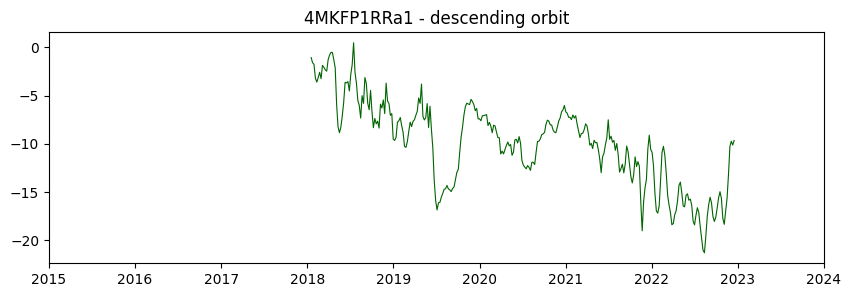

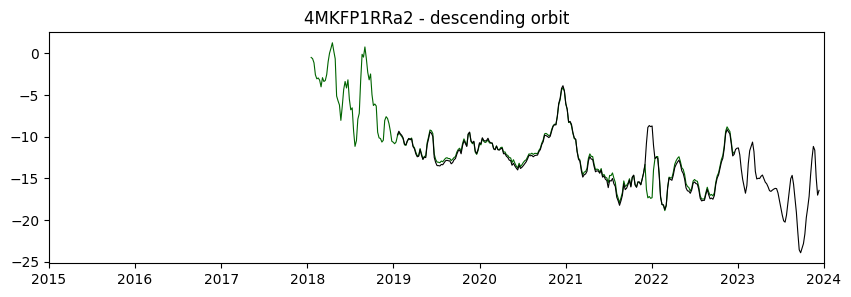

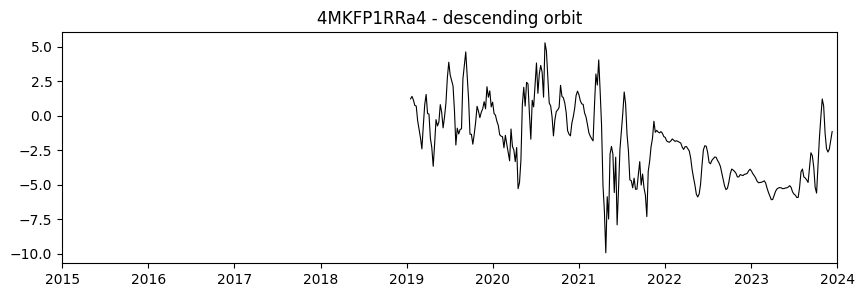

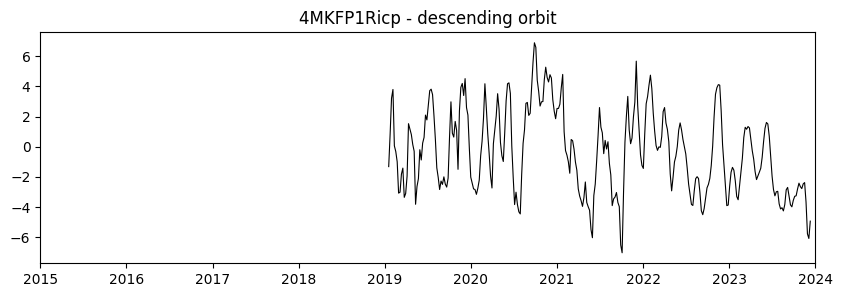

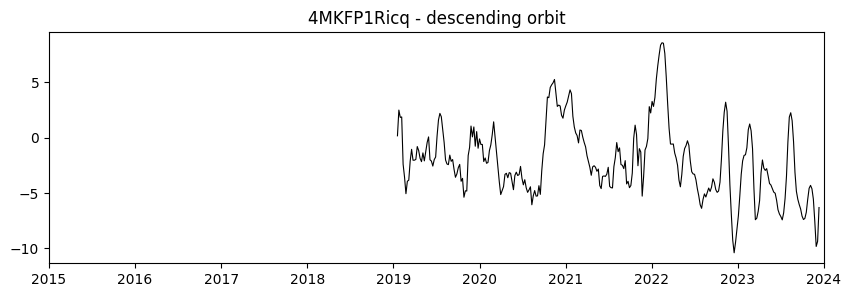

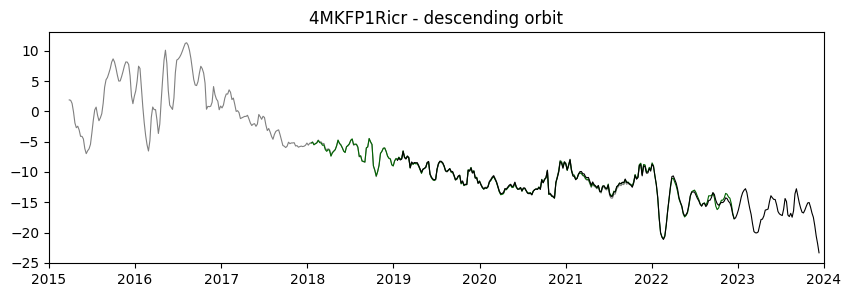

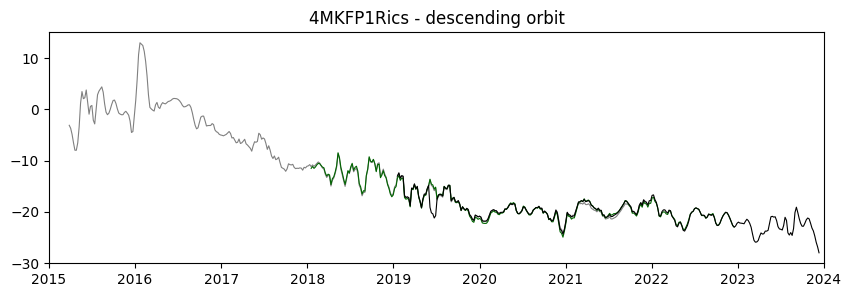

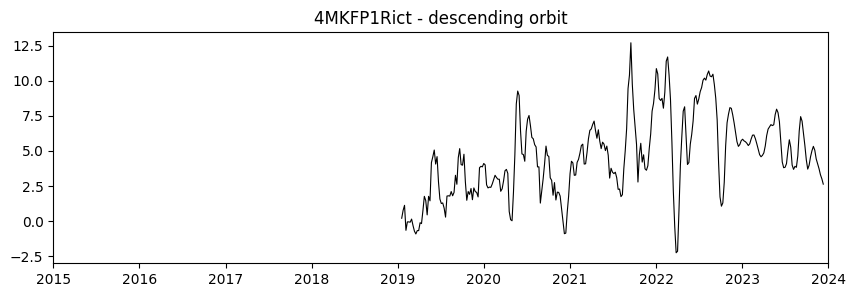

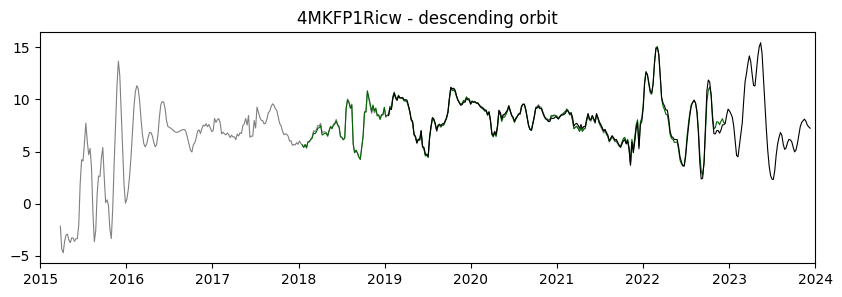

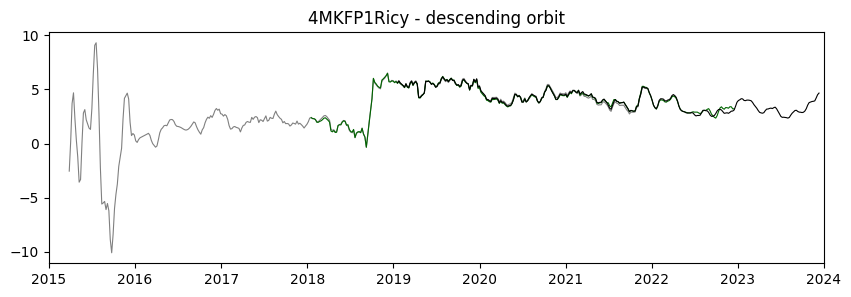

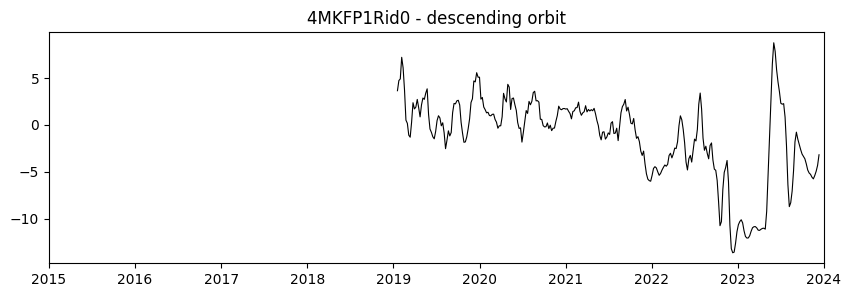

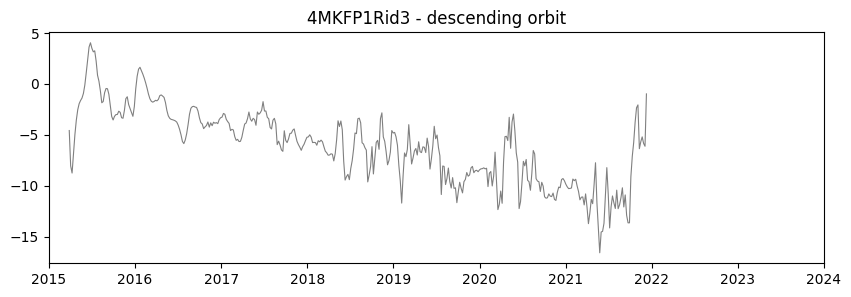

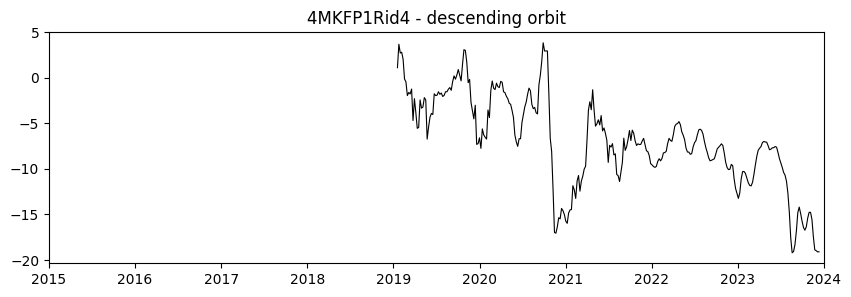

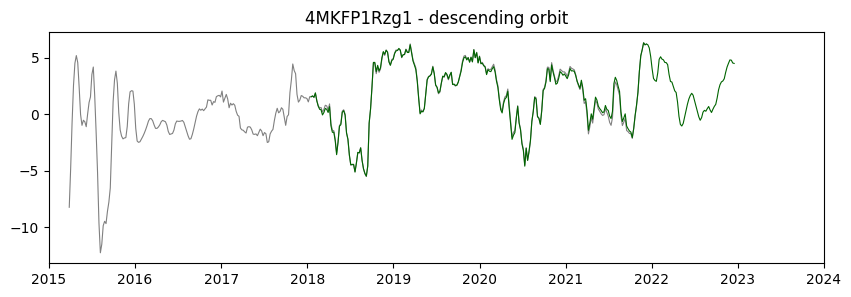

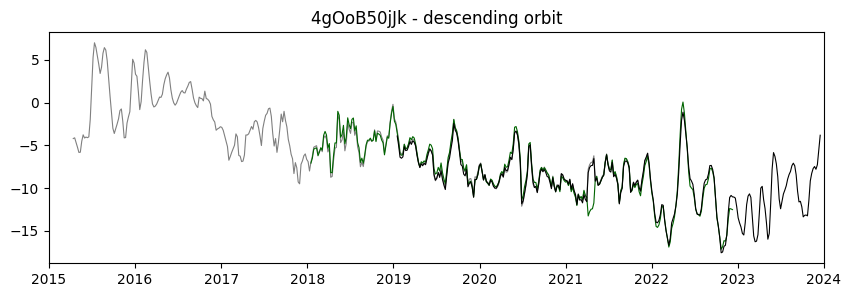

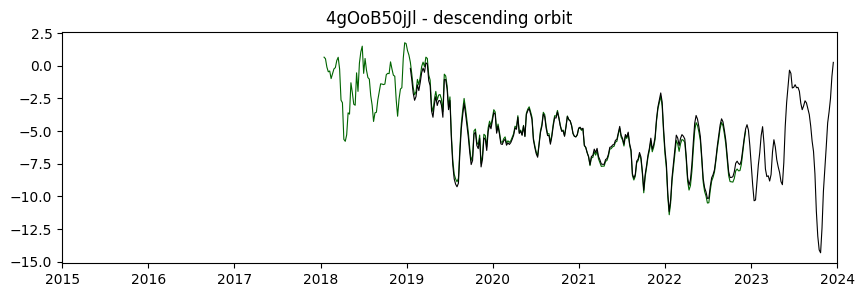

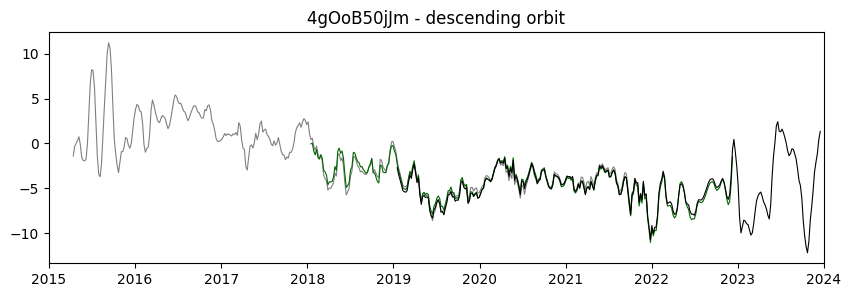

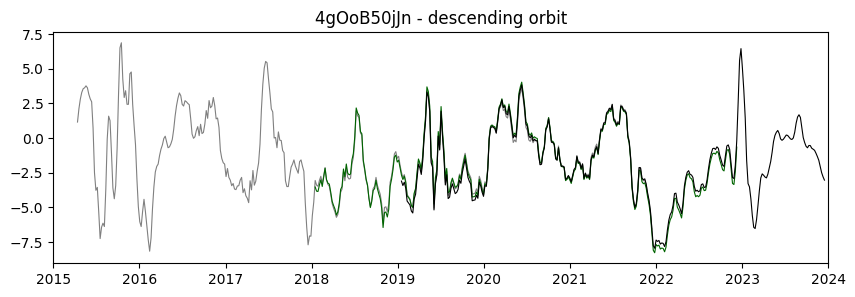

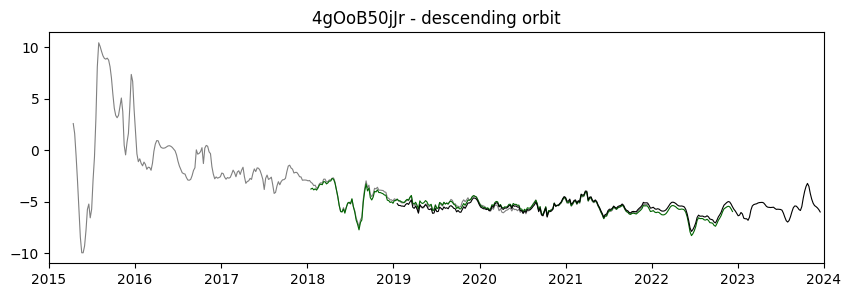

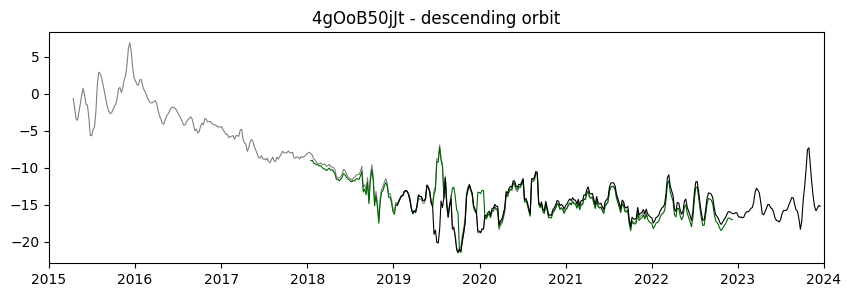

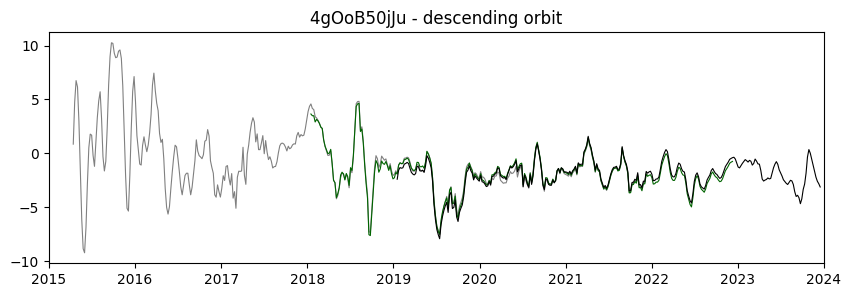

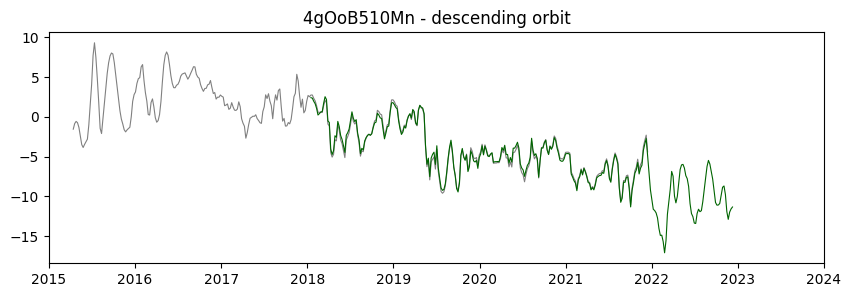

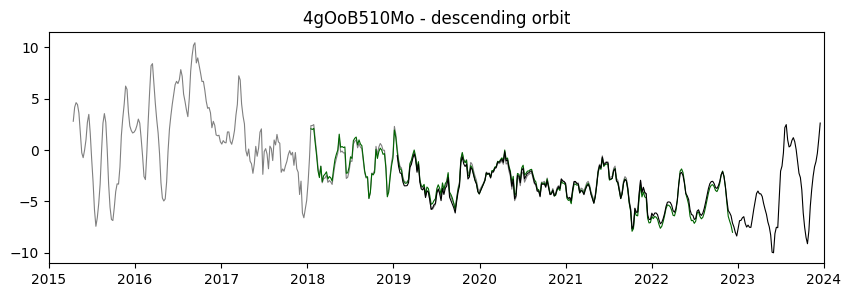

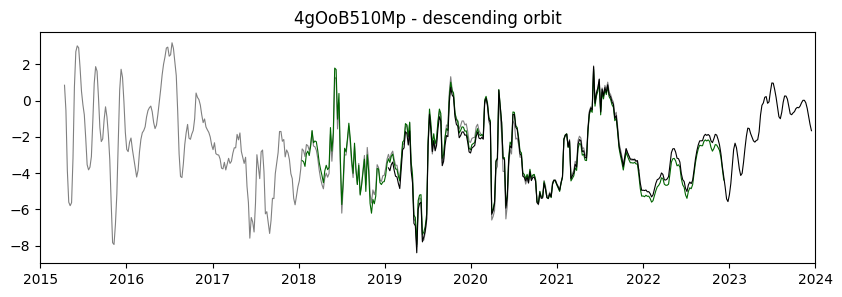

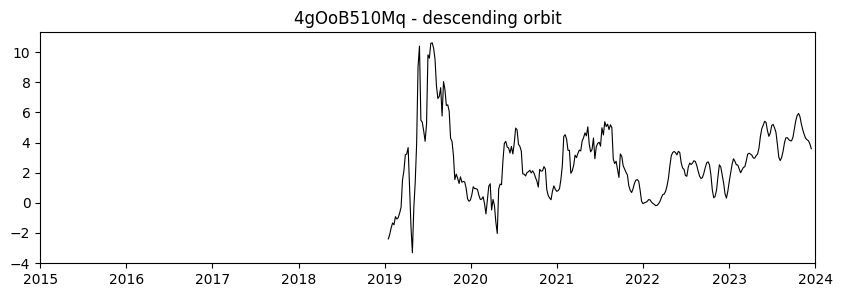

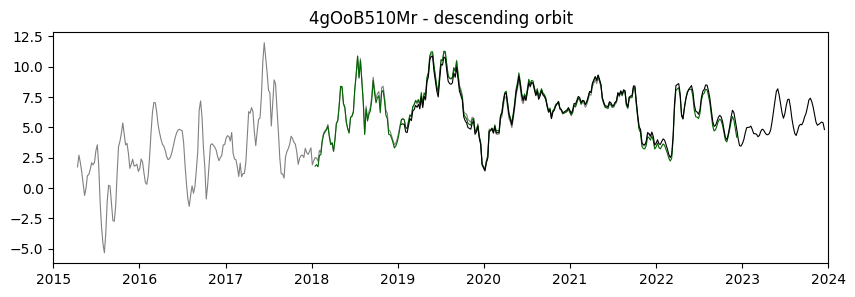

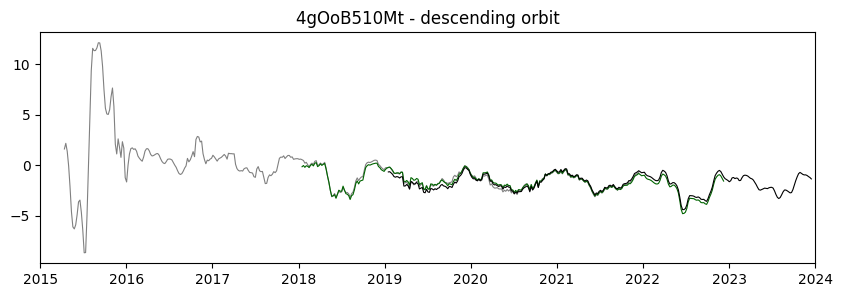

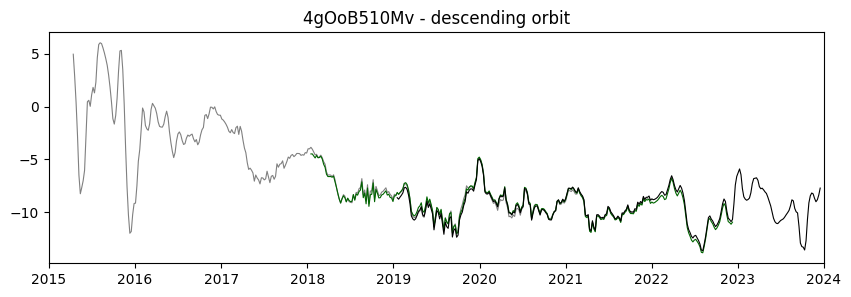

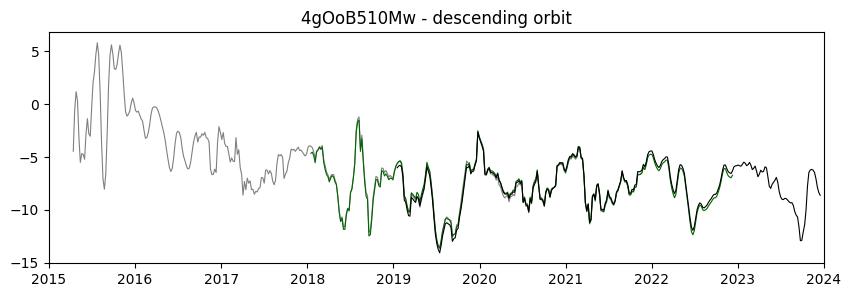

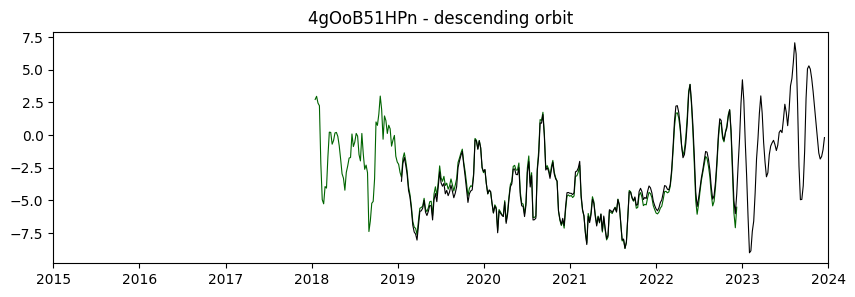

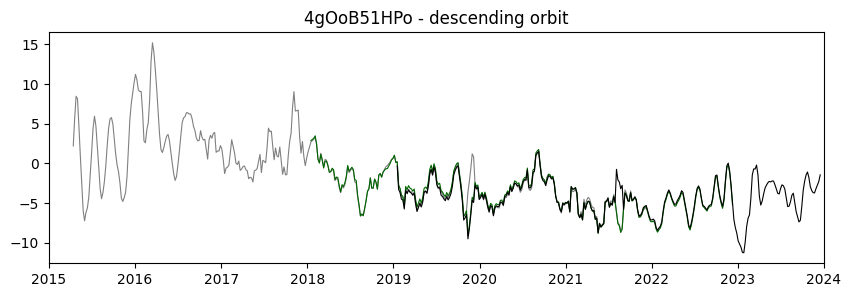

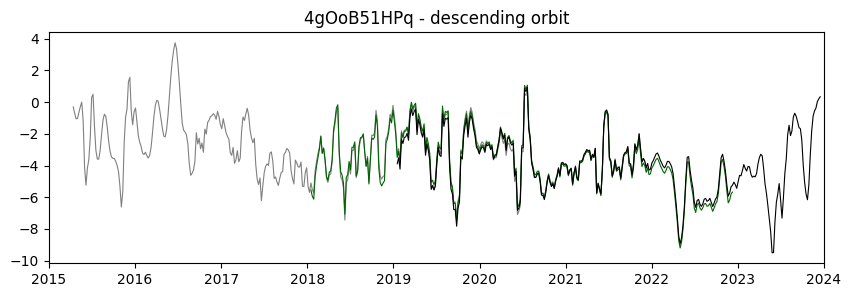

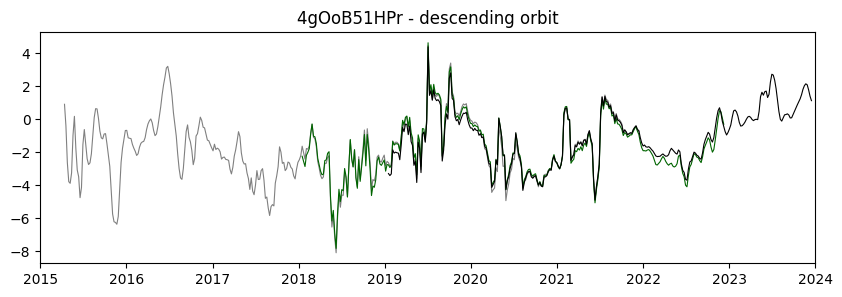

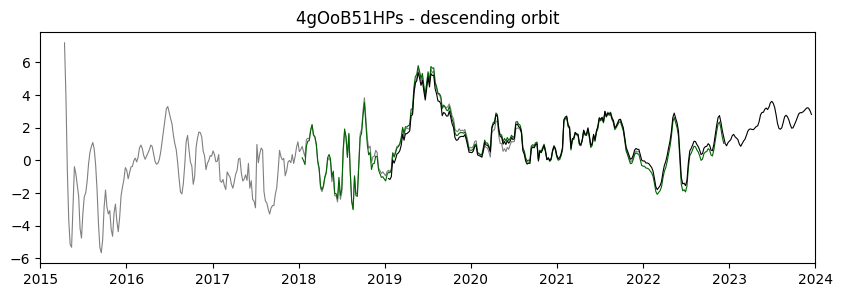

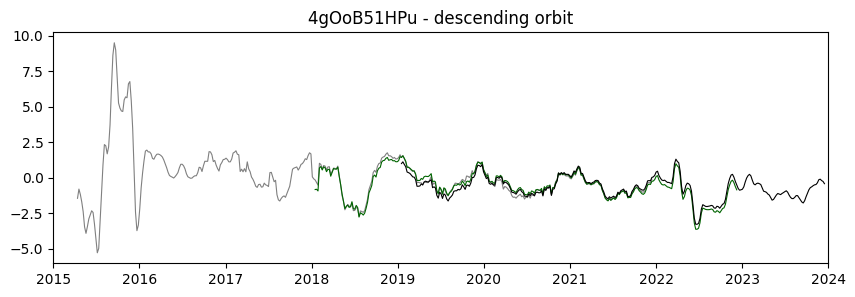

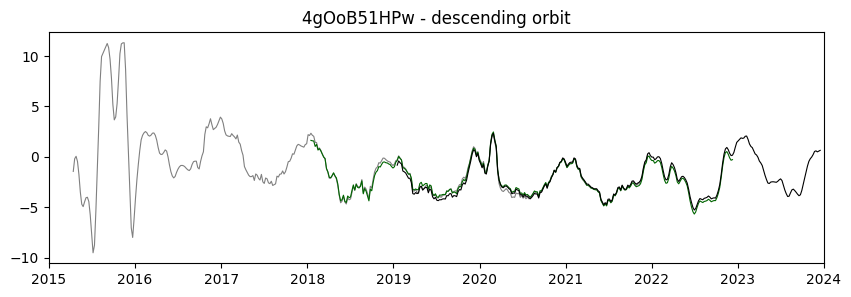

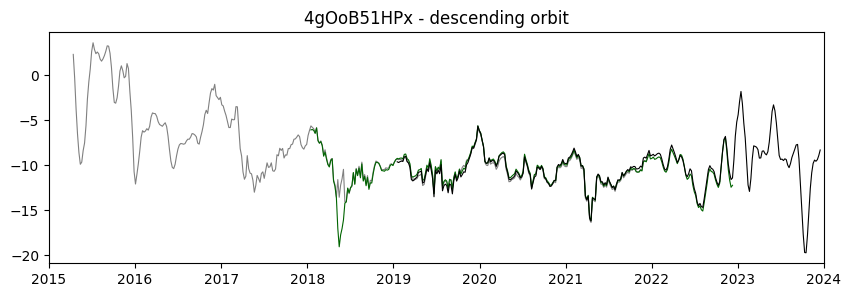

In [45]:
import matplotlib.pyplot as plt
colors = {'2015':'grey', '2018':'darkgreen', '2019':'black'}
for pid in df_aligned['pid'].unique():
    plt.style.use('default')
    plt.figure(figsize=(10, 3))

    pid_df = df_aligned[df_aligned['pid'] == pid]
    i=0
    for _, row in pid_df.iterrows():
        s = row[date_columns]
        s = s.dropna()
        s = s.rolling(5, center=True).mean()
        plt.plot(s, color=colors[row.start_year], linewidth=0.8)
        plt.xlim((pd.to_datetime('2015-01-01'), pd.to_datetime('2024-01-01')))
        plt.title(f'{pid} - {row.orbite} orbit')
        i += 1
    plt.savefig(f'figures/{pid} - orbite {row.orbite}')
    plt.show()
    plt.close()
